# EIT-CEM Quick-Start

In [9]:
import pickle
import seaborn as sns
import sys
sys.path.append('../../FEIT_codes') # Add the parent directory to the path list
from matplotlib.colors import LinearSegmentedColormap

#Importing modules
from FEIT_onefile import *


In [2]:
"Basic Definitions"
r=1            #Circle radius
L=16           #Number of Electrodes
per_cober=0.5  #Percentage of area covered by electrodes
rotate=0       #Rotation

#Return object with angular position of each electrode
ele_pos=electrodes_position(L, per_cober, rotate)
refine_n=8 #Refinement mesh
n_in=8     #Vertex on elec.
n_out=2    #Vertex on gaps (Sometimes it is important.)

mesh_inverse=MyMesh(r, refine_n, n_in, n_out, ele_pos)
mesh_forward=MyMesh(r, refine_n*3, n_in*3, n_out*3, ele_pos)

In [3]:
exp_name="exp1"
expDict = {"LW": "data/{}/LW.data".format(exp_name),
           "LM":"data/{}/LM.data".format(exp_name),
           "NLW":"data/{}/NLW.data".format(exp_name),
           "NTK":"data/{}/NTK.data".format(exp_name),}

dataDict = {}

for name in expDict.keys():
    data = open(expDict[name],'rb')
    mydict = pickle.load(data)
    data.close()
    dataDict[name] = {}
    dataDict[name]['res_vec'] = mydict["results"]["res_vec"]
    dataDict[name]['error_vec'] = mydict["results"]["error_vec"]
    dataDict[name]['tau'] = mydict["config"]["tau"]
    dataDict[name]['noise_level'] = mydict["config"]["noise_level"]
    dataDict[name]['time'] = mydict["results"]["time"]
    dataDict[name]['innerstep_vec'] = mydict["results"]["innerstep_vec"]
    dataDict[name]['gamma_k'] = mydict["results"]["gamma_k"][-2]

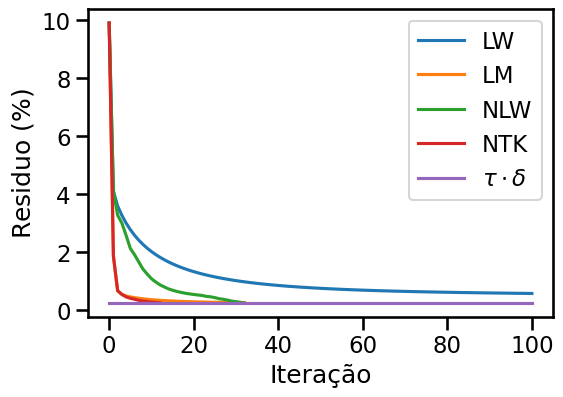

In [4]:
sns.set_context("talk")
#Residue Curve
plt.figure(figsize=(6, 4))
plt.ylabel(r'Residuo $(\%)$');
plt.xlabel('Iteração');
#plt.title('Residue');
max_resvec=1
for key, experiment in dataDict.items():   
    res_vec=experiment["res_vec"]
    max_resvec=max(max_resvec,len(res_vec))
    plt.plot(res_vec, label=key);
    delta, tau = dataDict[key]["noise_level"], dataDict[key]["tau"]
plt.plot(np.ones(max_resvec)*tau*delta*100, label=r"$\tau \cdot \delta$");
plt.legend()
plt.savefig("figures/{}/Residue.png".format(exp_name), bbox_inches='tight', transparent=True)
plt.show()

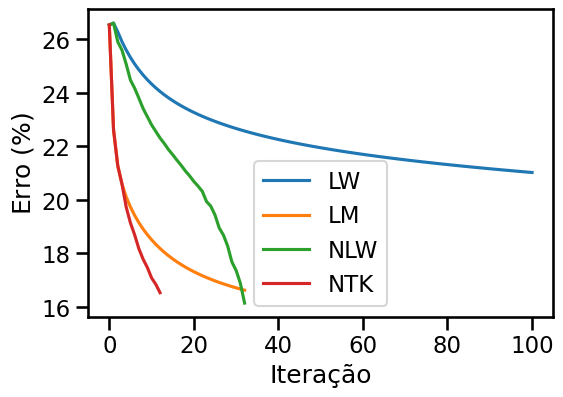

In [5]:
#Error curve
plt.figure(figsize=(6, 4))
plt.ylabel(r'Erro $(\%)$');
plt.xlabel('Iteração');
#plt.title('Error');
for key, experiment in dataDict.items():   
    error_vec=experiment["error_vec"]
    plt.plot(error_vec, label=key);
plt.legend()
plt.savefig("figures/{}/Error.png".format(exp_name), bbox_inches='tight', transparent=True)
plt.show()

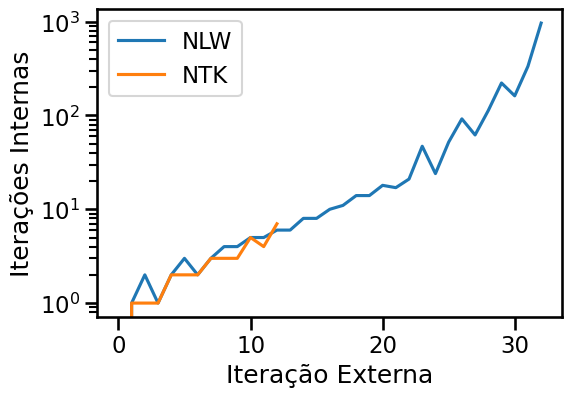

In [6]:
#Error curve
plt.figure(figsize=(6, 4))
plt.ylabel('Iterações Internas');
plt.xlabel('Iteração Externa');
#plt.title('Error');
for key, experiment in dataDict.items():  
    if key=="LM" or key=="LW": continue 
    error_vec=experiment["innerstep_vec"]
    plt.plot(error_vec, label=key);
plt.legend()
plt.yscale('log')
plt.savefig("figures/{}/InnerSteps.png".format(exp_name), bbox_inches='tight', transparent=True)
plt.show()

1.5269616311932253
1.8359407422249792
1.7992076449979493
1.8141661350168057


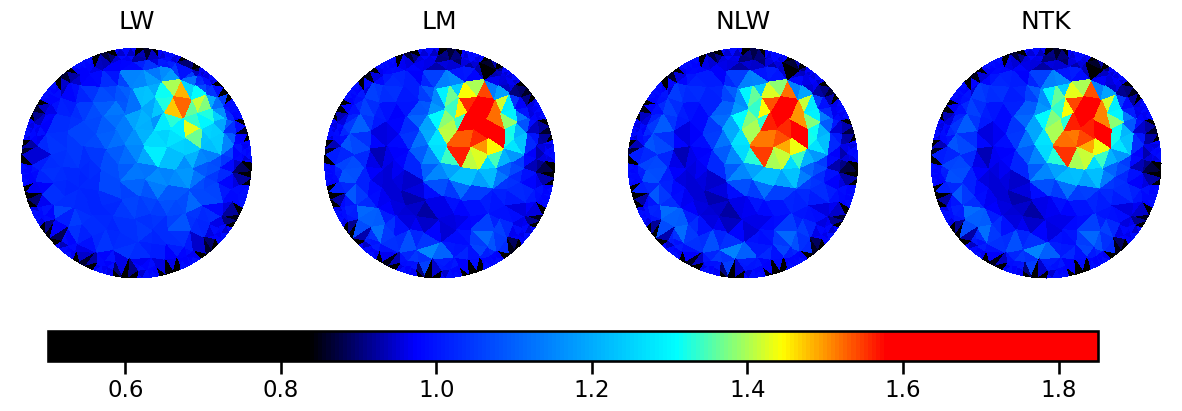

In [22]:
sns.set_context("talk")
fig=plt.figure(figsize=(15, 5))
cmap='jet'
sub_len=4

Q_DG=FunctionSpace(mesh_inverse, "DG", 0)
i=1
cmap = LinearSegmentedColormap.from_list('custom',
                                                    [(0, 'black'),
                                                     (0.5/2, 'black'),
                                                     (0.7/2, 'blue'),
                                                     (1.2/2, 'cyan'),
                                                     (1.4/2, 'yellow'),
                                                     (1.6/2, 'red'),
                                                     (1, 'red')], N=256)


for key, experiment in dataDict.items():
    gamma_k = Function(Q_DG)   
    gamma_k.vector()[:]=experiment["gamma_k"]

    plt.subplot(1,4,i);
    p=plot(gamma_k);
    print(np.max(gamma_k.vector()[:]))
    p.set_cmap(cmap)    
    p.set_clim(0.5,1.85)
    #if i==7+sub_len: plt.ylabel("Method 3")
    #plt.title(legend[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.title(key)
    i+=1

#fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.15, 0.10, 0.70, 0.015*4])
fig.colorbar(p, cax=cbar_ax, orientation="horizontal", )
#fig.suptitle('Newton (Landweber)', fontsize=16)

fig.savefig('figures/{}/2DSolutions.png'.format(exp_name), bbox_inches='tight', transparent=True, format='png')
plt.show()   

In [18]:
import pandas as pd
exps_names=list(dataDict.keys())
times=[np.round(dataDict[key]["time"],0) for key in dataDict.keys()]
errors=[np.round(dataDict[key]["error_vec"][-1],2) for key in dataDict.keys()]
res=[np.round(dataDict[key]["res_vec"][-1],2) for key in dataDict.keys()]
df = pd.DataFrame([res, errors, times])
df.index = ["$res_{n_\delta}$", "$E_{n_\delta}$", "Tempo (s)"]
print(df.to_latex(index=True,
                  header =exps_names,
                  column_format = "lcccc",
                  escape=False))

\begin{tabular}{lcccc}
\toprule
{} &     LW &     LM &    NLW &    NTK \\
\midrule
$res_{n_\delta}$ &   0.58 &   0.26 &   0.25 &   0.26 \\
$E_{n_\delta}$   &  21.02 &  16.62 &  16.14 &  16.53 \\
Tempo (s)        &  72.00 &  23.00 &  23.00 &   9.00 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_587/1170935698.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=True,
